Optimized scaling values for all datasets: alpha=2.840715620661265e-16, beta=2.7647039103117543, gamma=2.980252918293933, delta=1.674104752919539e-12


/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_64431/2041861454.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scale_values_df = pd.concat([scale_values_df, new_scale_values], ignore_index=True)


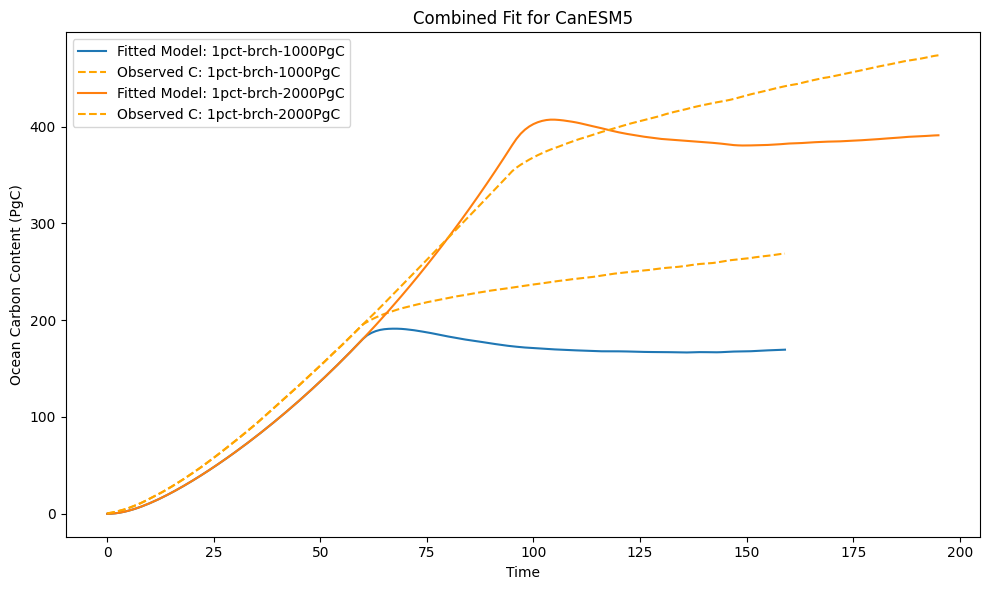

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the step temperature function
def step_temperature_e(S_old, F, q, d, dt=1):
    decay_factor = np.exp(-dt / d)
    S_new = q * F * (1 - decay_factor) + S_old * decay_factor
    T = np.sum((S_old + S_new) / 2)
    return S_new, T

# Define the function for calculating cumulative output based on alpha, beta, gamma
def only_leave_params_to_be_set(time, alpha, beta, gamma, delta, conc_data):
    q_test = np.array([0.180 * alpha, 0.297 * beta, 0.386 * gamma, 0.1*delta])  # q values
    d_test = np.array([0.903, 7.92, 355, 1000000]) # d values (set)
    C_test_values = np.array(conc_data - conc_data[0], dtype=float)
    C_output = np.zeros(len(C_test_values), dtype=float)

    S_test, C_output[0] = step_temperature_e(S_old=0, F=C_test_values[0], q=q_test, d=d_test, dt=1)

    for t in range(1, len(C_test_values)):
        S_test, C_output[t] = step_temperature_e(S_old=S_test, F=C_test_values[t], q=q_test, d=d_test, dt=1)

    return C_output.astype(float)

# Combine fitting procedure for all datasets
def ESM_fitting_procedure(fgco2, conc, datasets, dataset_name, scale_values_df):

    # Initialize a combined time and data array for fitting
    combined_time = []
    combined_C = []
    combined_conc_data = []

    # Loop through each dataset to combine the data together
    for label in datasets:
        fgco2_data = fgco2[label]
        C = np.cumsum(fgco2_data)

        conc_data = conc[label]
        time = np.arange(len(conc_data))

        # Ensure consistent length in time, conc_data and C for fitting
        min_length = min(len(C), len(conc_data))
        C = C[:min_length]
        conc_data = conc_data[:min_length]
        time = time[:min_length]

        # Append the data for the combined fitting
        combined_time.extend(time)
        combined_C.extend(C)
        combined_conc_data.extend(conc_data)

    # Convert combined lists to numpy arrays for curve fitting
    combined_time = np.array(combined_time)
    combined_C = np.array(combined_C)
    combined_conc_data = np.array(combined_conc_data)

    # Initial parameter guess and bounds
    bounds = (0, [np.inf, np.inf, np.inf, np.inf])
    p0 = [1, 1, 1, 1]

    # Perform curve fitting using the combined data from all datasets
    popt, pcov = curve_fit(lambda t, alpha, beta, gamma, delta: only_leave_params_to_be_set(t, alpha, beta, gamma, delta, combined_conc_data), 
                           combined_time, combined_C, p0=p0, bounds=bounds)

    # Optimized parameters
    alpha_opt, beta_opt, gamma_opt, delta_opt = popt
    print(f"Optimized scaling values for all datasets: alpha={alpha_opt}, beta={beta_opt}, gamma={gamma_opt}, delta={delta_opt}")

    # Update scale values dataframe
    new_scale_values = pd.DataFrame({'Dataset': [f'{dataset_name}'], 'alpha': [alpha_opt], 'beta': [beta_opt], 'gamma': [gamma_opt], 'delta': [delta_opt]})
    scale_values_df = pd.concat([scale_values_df, new_scale_values], ignore_index=True)

    # Plot the combined observed and fitted data
    plt.figure(figsize=(10, 6))

    for label in datasets:
        fgco2_data = fgco2[label]
        C = np.cumsum(fgco2_data)

        conc_data = conc[label]
        time = np.arange(len(conc_data))

        # Ensure consistent length for plotting
        min_length = min(len(C), len(conc_data))
        C = C[:min_length]
        conc_data = conc_data[:min_length]
        time = time[:min_length]

        # Generate fitted model output with the optimized parameters
        C_output_optimized = only_leave_params_to_be_set(time, alpha_opt, beta_opt, gamma_opt, delta_opt, conc_data)

        # Plot the fitted model and the observed data
        plt.plot(time, C_output_optimized, label=f'Fitted Model: {label}')
        plt.plot(time, C, 'orange', label=f'Observed C: {label}', linestyle='dashed')

    plt.title(f'Combined Fit for {dataset_name}')
    plt.xlabel('Time')
    plt.ylabel('Ocean Carbon Content (PgC)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'ESM_fit_{dataset_name}.png')

    return plt, scale_values_df


# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CanESM5/CanESM/fgco2_CanESM5_esm-1pct-brch-1000PgC_1851_2010.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/CanESM5/CanESM/fgco2_CanESM5_esm-1pct-brch-2000PgC_1947_2010.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CanESM5/CanESM/co2_CanESM5_esm-1pct-brch-1000PgC_1851_2010.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/CanESM5/CanESM/co2_CanESM5_esm-1pct-brch-2000PgC_1947_2010.csv', index_col=0).to_numpy().flatten(),
}

scale_values_df = pd.DataFrame(columns=['Dataset', 'alpha', 'beta', 'gamma', 'delta'])

# Perform fitting procedure and generate the plot
plt, scale_values_df = ESM_fitting_procedure(fgco2=fgco2, conc=conc, datasets=datasets, dataset_name='CanESM5', scale_values_df=scale_values_df)


Optimized scaling values for all datasets: alpha=1.6167547935896432e-10, beta=3.3592603414812374, gamma=1.4149589402017775, delta=1.722055596685548e-07


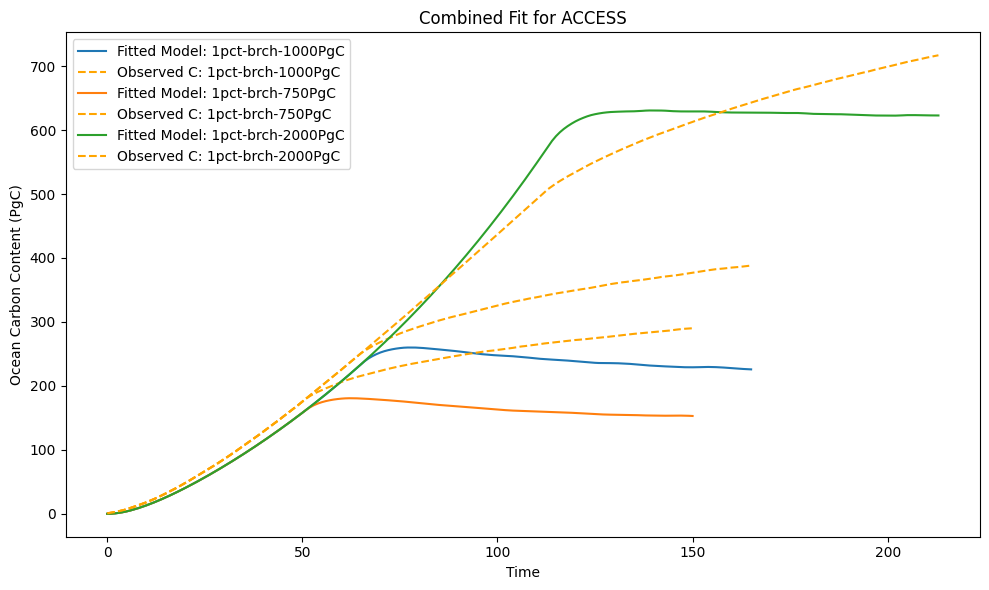

In [247]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-750PgC', '1pct-brch-2000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/fgco2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A2/fgco2_ACCESS-ESM1.5_esm-1pct-brch-750PgC_54-153.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A3/fgco2_ACCESS-ESM1.5_esm-1pct-brch-2000PgC_116-215.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/co2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A2/co2_ACCESS-ESM1.5_esm-1pct-brch-750PgC_54-153.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/ACCESS/ACCESS_A3/co2_ACCESS-ESM1.5_esm-1pct-brch-2000PgC_116-215.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(fgco2 = fgco2, conc = conc, datasets = datasets, dataset_name = 'ACCESS', scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=1.4517350378117169, beta=1.3144051027521673, gamma=8.905041520632453, delta=4.4711349784249334e-14


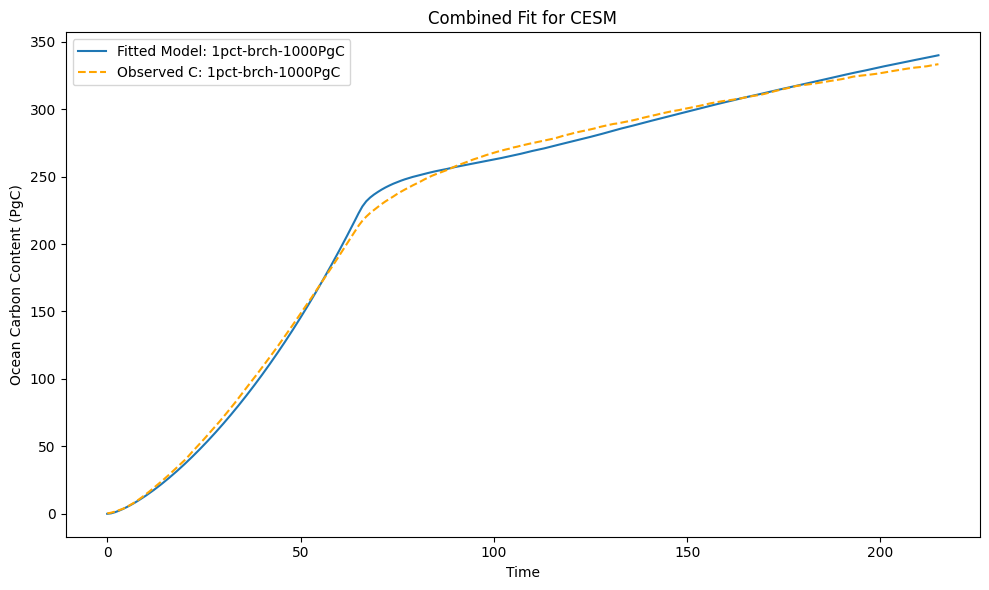

In [227]:
# Load data
datasets = ['1pct-brch-1000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CESM/CESM_A1/fgco2_cesm2_esm-1pct-brch-1000PgC_0001_0150.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CESM/CESM_A1/co2_cesm2_esm-1pct-brch-1000PgC_0001_0150.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(fgco2 = fgco2, conc = conc, datasets = datasets, dataset_name = 'CESM', scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=0.6635172660708302, beta=1.8055835293023943, gamma=10.837718964793185, delta=5.498356098676018e-17


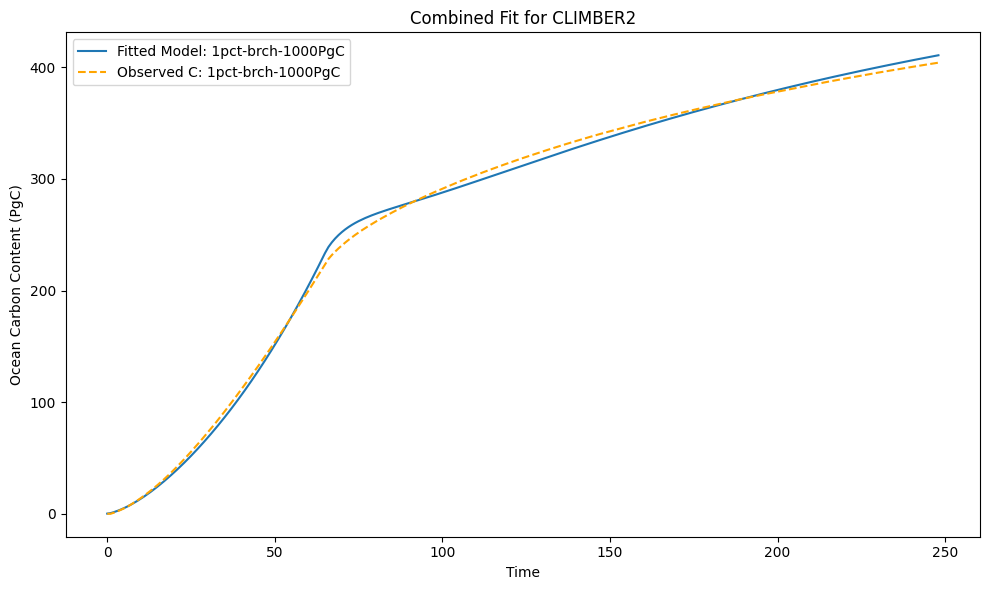

In [228]:
# Load data
datasets = ['1pct-brch-1000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CLIMBER2/CLIMBER2_A1/fgco2_CLIMBER2_esm-1pct-brch-1000PgC_1850_2100.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CLIMBER2/CLIMBER2_A1/co2_CLIMBER2_esm-1pct-brch-1000PgC_1850_2100.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(fgco2 = fgco2, conc = conc, datasets = datasets, dataset_name = 'CLIMBER2', scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=5.346764706207987e-14, beta=1.584082798271928, gamma=6.749245737565261, delta=1.48056296778039e-18


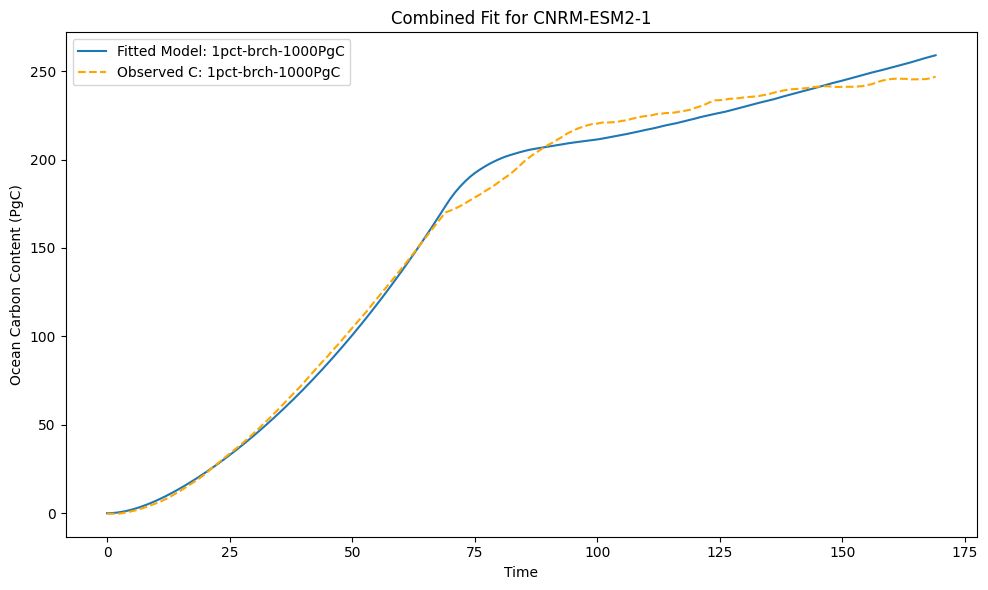

In [229]:
# Load data
datasets = ['1pct-brch-1000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CNRM-ESM2-1/CNRM_ZECMIP/fgco2_CNRM-ESM2-1_esm-1pct-brch-1000PgC_r1i1p1_192001-202012.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/CNRM-ESM2-1/CNRM_ZECMIP/co2_CNRM-ESM2-1_esm-1pct-brch-1000PgC_r1i1p1_192001-202012.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(fgco2 = fgco2, conc = conc, datasets = datasets, dataset_name = 'CNRM-ESM2-1', scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=0.6647072788959776, beta=0.4720580559165261, gamma=8.392689182494003, delta=1.6191058982393404e-14


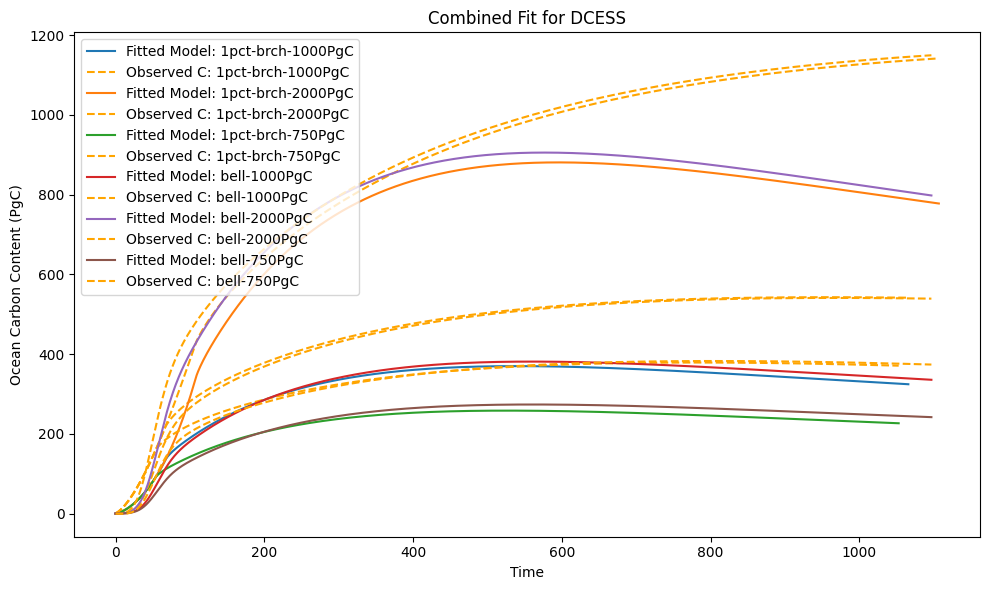

In [230]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_1000PgC/fgco2_DCESS1.0_esm-1pct-brch-1000PgC_1765-2833.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_2000PgC/fgco2_DCESS1.0_esm-1pct-brch-2000PgC_1765_2874.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_750PgC/fgco2_DCESS1.0_esm-1pct-brch-750PgC_1765_2820.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_1000PgC/fgco2_DCESS1.0_esm-bell-1000PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_2000PgC/fgco2_DCESS1.0_esm-bell-2000PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_750PgC/fgco2_DCESS1.0_esm-bell-750PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_1000PgC/co2_DCESS1.0_esm-1pct-brch-1000PgC_1765-2833.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_2000PgC/co2_DCESS1.0_esm-1pct-brch-2000PgC_1765_2874.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_1pct_brch_750PgC/co2_DCESS1.0_esm-1pct-brch-750PgC_1765_2820.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_1000PgC/co2_DCESS1.0_esm-bell-1000PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_2000PgC/co2_DCESS1.0_esm-bell-2000PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/DCESS/DCESS1.0_emic_bell_brch_750PgC/co2_DCESS1.0_esm-bell-750PgC_1765_2864.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(dataset_name = 'DCESS', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=2.037160894438898e-09, beta=4.4408063253507155, gamma=3.6229366247522155, delta=1.986840936548683e-26


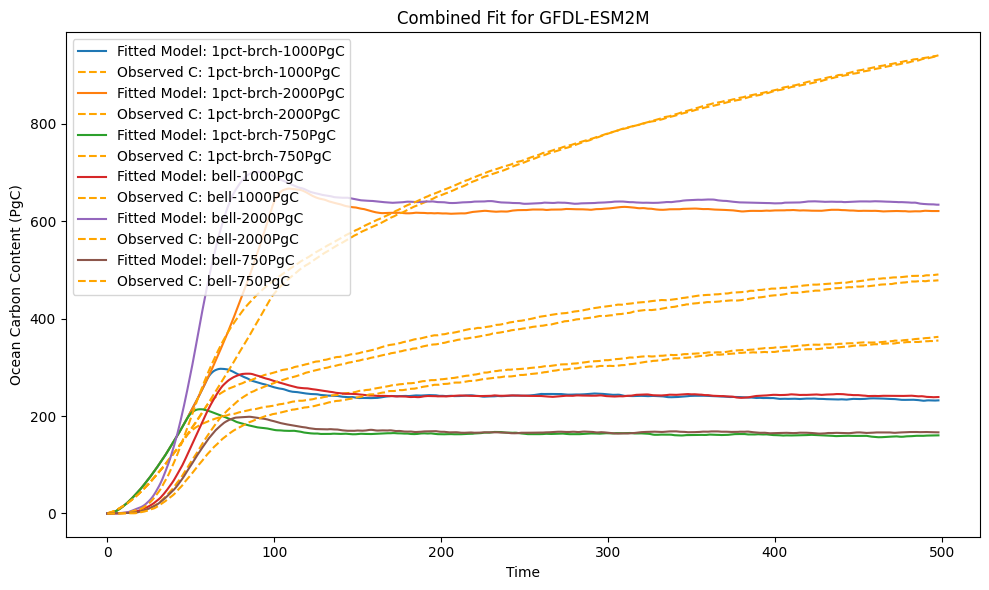

In [231]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-1pct-brch-1000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-1pct-brch-2000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-1pct-brch-750PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-bell-1000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-bell-2000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/fgco2_GFDL-ESM2M_esm-bell-750PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-1pct-brch-1000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-1pct-brch-2000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-1pct-brch-750PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-bell-1000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-bell-2000PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/GFDL-ESM2M/ZEC-MIP_data_csv/co2_GFDL-ESM2M_esm-bell-750PgC_1861_2360.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(dataset_name = 'GFDL-ESM2M', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=1.0638625981749497e-12, beta=4.839174791960535, gamma=5.515552344674768, delta=9.617751520778008e-11


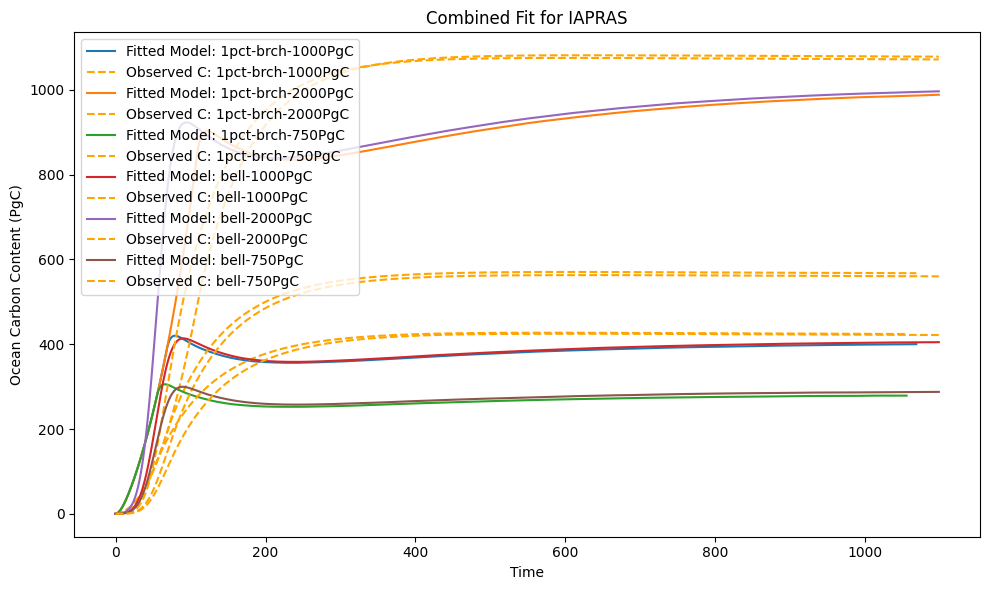

In [232]:
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-1000PgC/fgco2_IAPRAS_esm-1pct-brch-1000PgC_1_1070.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-2000PgC/fgco2_IAPRAS_esm-1pct-brch-2000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-750PgC/fgco2_IAPRAS_esm-1pct-brch-750PgC_1_1057.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/IAPRAS/bell-1000PgC/fgco2_IAPRAS_esm-bell-1000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/IAPRAS/bell-2000PgC/fgco2_IAPRAS_esm-bell-2000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/IAPRAS/bell-750PgC/fgco2_IAPRAS_esm-bell-750PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-1000PgC/co2_IAPRAS_esm-1pct-brch-1000PgC_1_1070.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-2000PgC/co2_IAPRAS_esm-1pct-brch-2000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/IAPRAS/abrupt-750PgC/co2_IAPRAS_esm-1pct-brch-750PgC_1_1057.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/IAPRAS/bell-1000PgC/co2_IAPRAS_esm-bell-1000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/IAPRAS/bell-2000PgC/co2_IAPRAS_esm-bell-2000PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/IAPRAS/bell-750PgC/co2_IAPRAS_esm-bell-750PgC_1_1100.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(dataset_name = 'IAPRAS', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=3.970271122310696e-07, beta=0.9249080376262364, gamma=9.363510566578755, delta=3.4491997988363265e-30


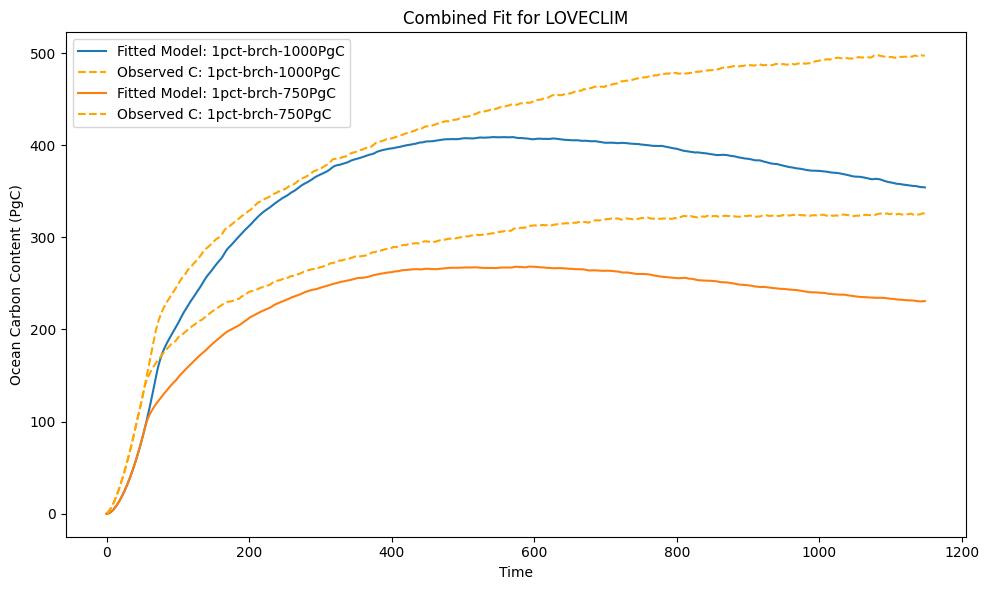

In [233]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/LOVECLIM/LOVECLIM1000PgCNew/fgco2_LOVECLIM_esm-1pct-brch-1000PgC_1850-3000.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/LOVECLIM/LOVECLIM750PgCNew/fgco2_LOVECLIM_esm-1pct-brch-750PgC_1850-3000.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/LOVECLIM/LOVECLIM1000PgCNew/co2_LOVECLIM_esm-1pct-brch-1000PgC_1850-3000.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/LOVECLIM/LOVECLIM750PgCNew/co2_LOVECLIM_esm-1pct-brch-750PgC_1850-3000.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(dataset_name = 'LOVECLIM', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=0.6369964848420067, beta=2.5922583663793444, gamma=8.417709654622882, delta=7.69858714506719e-14


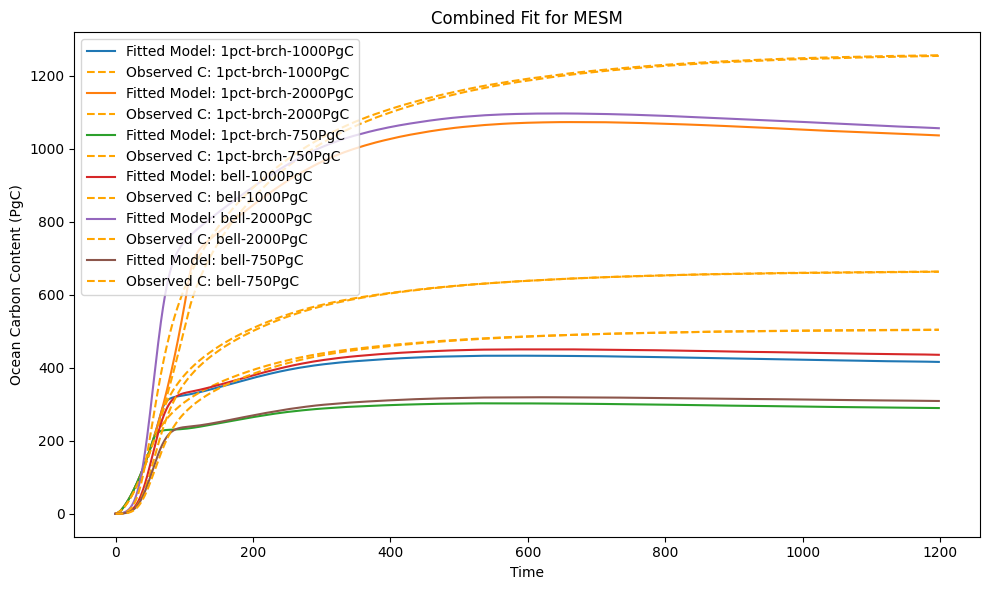

In [234]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%1000GtC/fgco2_MESM_esm-1pct-brch-1000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%2000GtC/fgco2_MESM_esm-1pct-brch-2000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%750GtC/fgco2_MESM_esm-1pct-brch-750PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_1000/fgco2_MESM_esm-bell-1000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_2000/fgco2_MESM_esm-bell-2000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_750/fgco2_MESM_esm-bell-750PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%1000GtC/co2_MESM_esm-1pct-brch-1000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%2000GtC/co2_MESM_esm-1pct-brch-2000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MESM/Data_for_1%750GtC/co2_MESM_esm-1pct-brch-750PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_1000/co2_MESM_esm-bell-1000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_2000/co2_MESM_esm-bell-2000PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/MESM/Data_for_Bell_750/co2_MESM_esm-bell-750PgC_1_1200.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(dataset_name = 'MESM', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=2.9270048507075606, beta=2.232846006856908, gamma=6.658530382423301e-17, delta=12.820646507527275


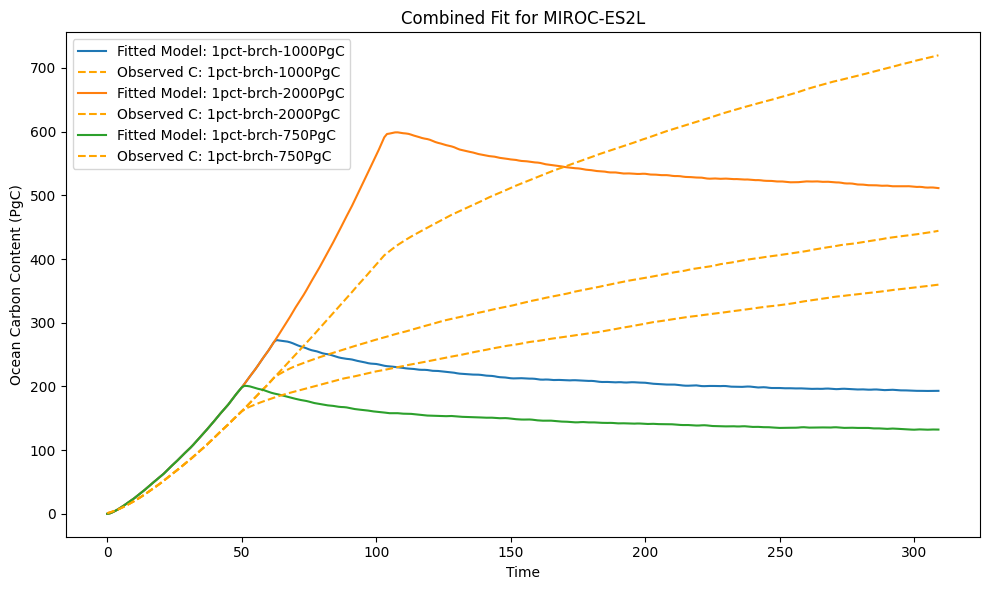

In [235]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/fgco2_MIROC-ES2L_esm-1pct-brch-1000PgC_1913_2160.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/fgco2_MIROC-ES2L_esm-1pct-brch-2000PgC_1954_2160.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/fgco2_MIROC-ES2L_esm-1pct-brch-750PgC_1901_2160.csv', index_col=0).to_numpy().flatten(),
    }

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/co2_MIROC-ES2L_esm-1pct-brch-1000PgC_1913_2160.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/co2_MIROC-ES2L_esm-1pct-brch-2000PgC_1954_2160.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MIROC-ES2L/data_MIROC-ES2L_hajima_00_190614/co2_MIROC-ES2L_esm-1pct-brch-750PgC_1901_2160.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(dataset_name = 'MIROC-ES2L', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=0.010476980265732678, beta=2.1164412337934612e-07, gamma=14.231315702838518, delta=4.833243803418525e-15


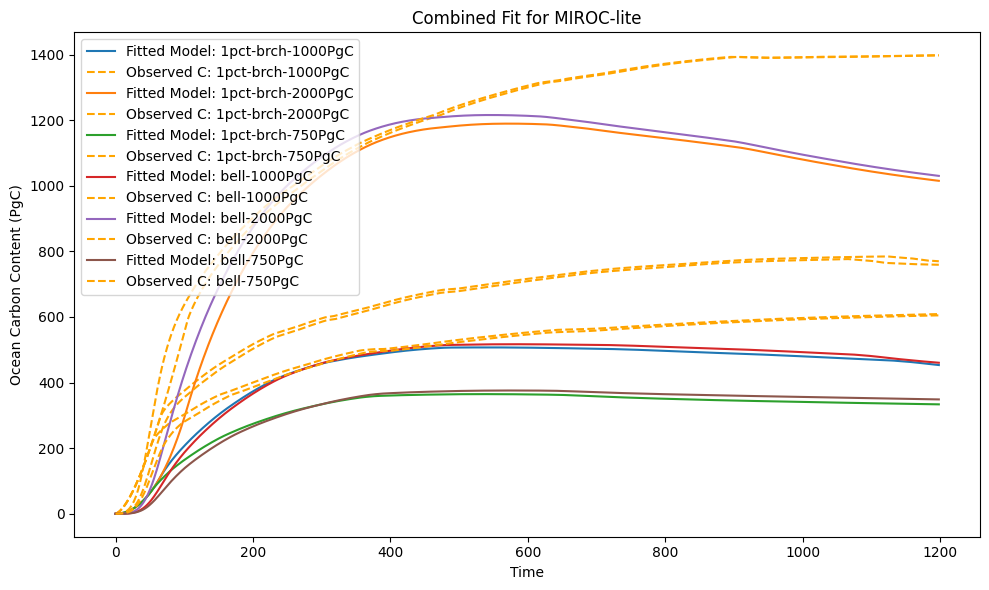

In [236]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MIROC-lite/A1_zec_1000PgC/fgco2_MIROC-lite-LCM_esm-1pct-brch-1000PgC_66-1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MIROC-lite/A2_zec_750PgC/fgco2_MIROC-lite-LCM_esm-1pct-brch-750PgC_54-1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MIROC-lite/A3_zec_2000PgC/fgco2_MIROC-lite-LCM_esm-1pct-brch-2000PgC_106-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/MIROC-lite/B1_bellshape_1000PgC/fgco2_MIROC-lite-LCM_esm-bell-1000PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/MIROC-lite/B2_bellshape_750PgC/fgco2_MIROC-lite-LCM_esm-bell-750PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/MIROC-lite/B3_bellshape_2000PgC/fgco2_MIROC-lite-LCM_esm-bell-2000PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MIROC-lite/A1_zec_1000PgC/co2_MIROC-lite-LCM_esm-1pct-brch-1000PgC_66-1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/MIROC-lite/A2_zec_750PgC/co2_MIROC-lite-LCM_esm-1pct-brch-750PgC_54-1200.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/MIROC-lite/A3_zec_2000PgC/co2_MIROC-lite-LCM_esm-1pct-brch-2000PgC_106-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/MIROC-lite/B1_bellshape_1000PgC/co2_MIROC-lite-LCM_esm-bell-1000PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/MIROC-lite/B2_bellshape_750PgC/co2_MIROC-lite-LCM_esm-bell-750PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/MIROC-lite/B3_bellshape_2000PgC/co2_MIROC-lite-LCM_esm-bell-2000PgC_1-1200.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(dataset_name = 'MIROC-lite', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=1.3007108638119822, beta=1.3208403475384478, gamma=10.582331365628994, delta=9.611658844753645e-15


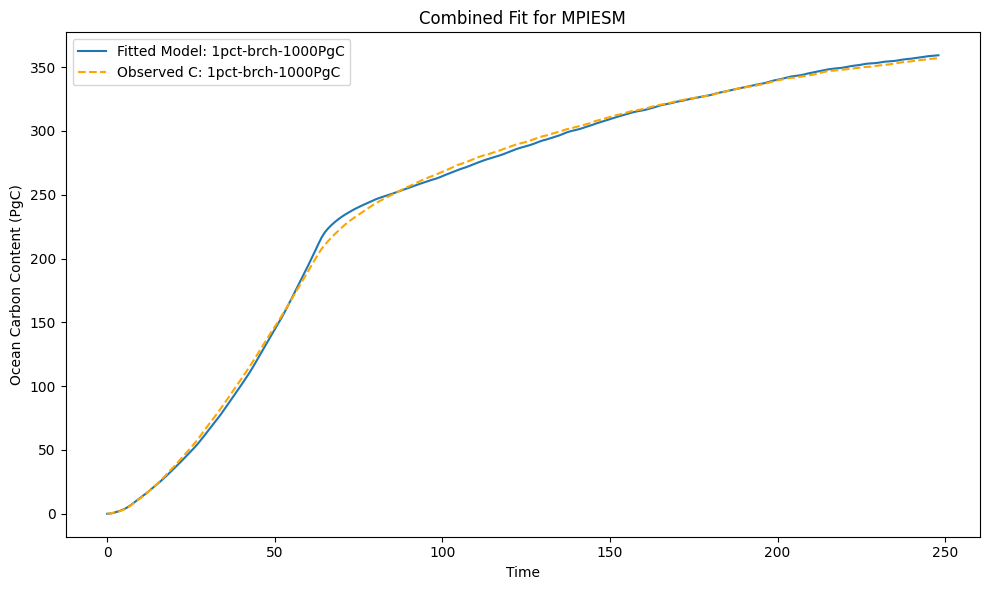

In [237]:
# Load data
datasets = ['1pct-brch-1000PgC']

fgco2 = {
    '1pct-brch-1000PgC': -1 * pd.read_csv('all_zecmip/MPIESM/MPIESM_A1/fgco2_MPIESM_esm-1pct-brch-1000PgC_1850-2099.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/MPIESM/MPIESM_A1/co2_MPIESM_esm-1pct-brch-1000PgC_1850-2099.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(fgco2 = fgco2, conc = conc, datasets = datasets, dataset_name = 'MPIESM', scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=9.607512330328469e-14, beta=2.384097391794232, gamma=3.7384752715127294, delta=1.8089937879704922e-14


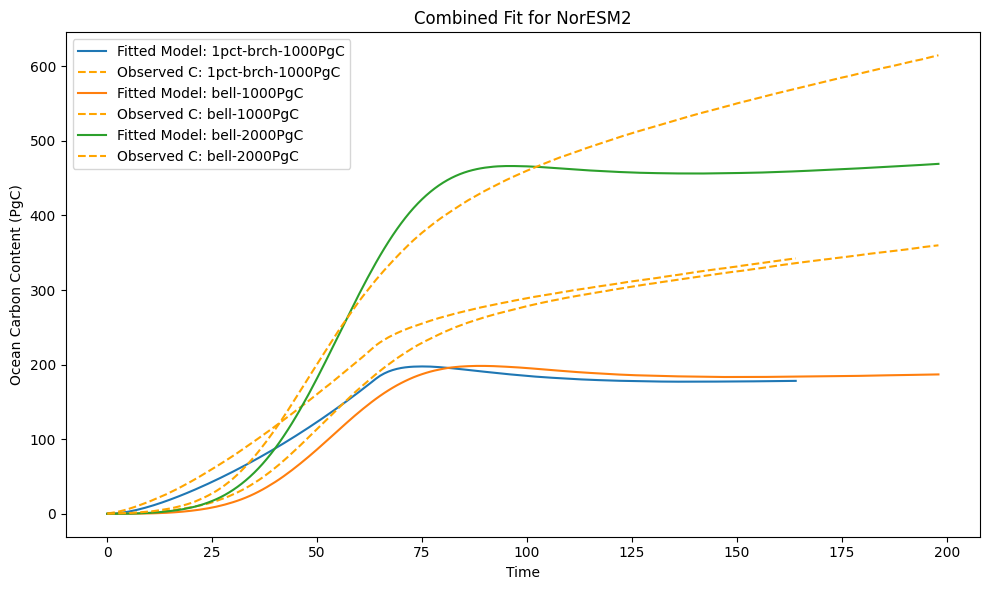

In [238]:
# Load data
datasets = ['1pct-brch-1000PgC', 'bell-1000PgC', 'bell-2000PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-A1/fgco2_NorESM2-LM_esm-1pct-brch-1000PgC_0066-0167.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-B1/fgco2_NorESM2-LM_esm-bell-1000PgC_1850-2049.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-B3/fgco2_NorESM2-LM_esm-bell-2000PgC_1850-2049.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-A1/co2_NorESM2-LM_esm-1pct-brch-1000PgC_0066-0167.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-B1/co2_NorESM2-LM_esm-bell-1000PgC_1850-2049.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/NorESM2/NorESM2-B3/co2_NorESM2-LM_esm-bell-2000PgC_1850-2049.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(dataset_name = 'NorESM2', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=2.580721953847028, beta=1.3421597755613301, gamma=10.0452142479547, delta=1.8426990664407535e-14


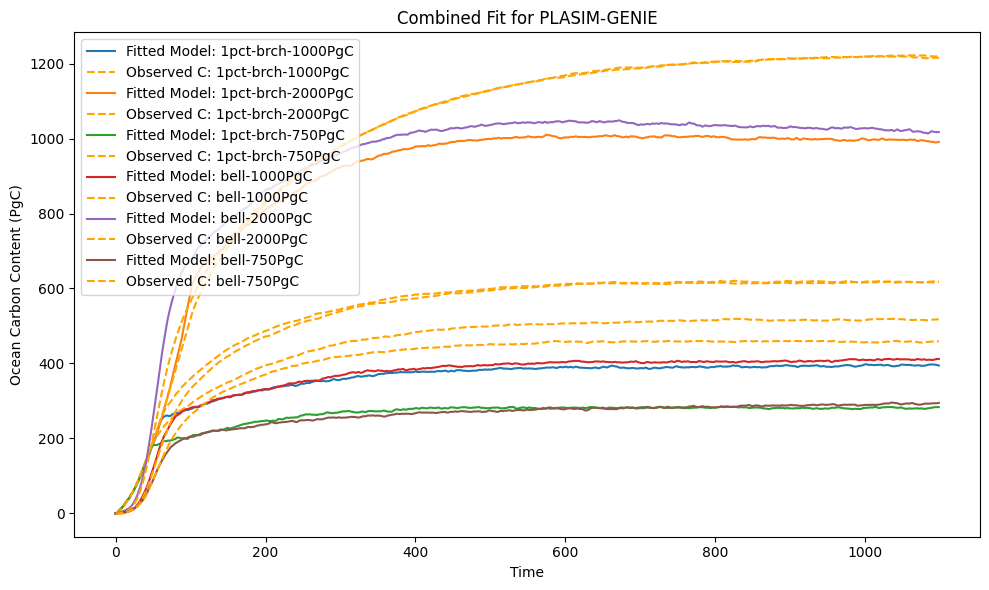

In [239]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-1pct-brch-1000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-1pct-brch-2000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-1pct-brch-750PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-bell-1000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-bell-2000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/fgco2_PLASIM-GENIE_esm-bell-750PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-1pct-brch-1000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-1pct-brch-2000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-1pct-brch-750PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-bell-1000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-bell-2000PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/PLASIM-GENIE/ZEC_OUTPUT/co2_PLASIM-GENIE_esm-bell-750PgC_0001_1100.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(dataset_name = 'PLASIM-GENIE', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=4.73808384710307, beta=0.3549953215130807, gamma=3.907826359566017e-14, delta=6.094577963093483


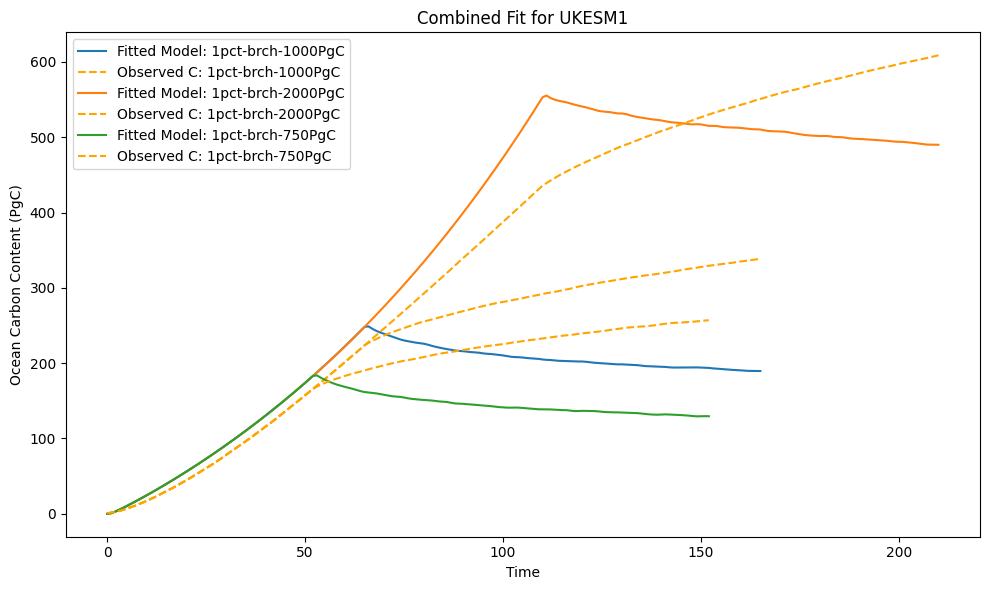

In [240]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-1000PgC/fgco2_UKESM1_esm-1pct-brch-1000PgC_1917_2016.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-2000PgC/fgco2_UKESM1_esm-1pct-brch-2000PgC_1962_2061.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-750PgC/fgco2_UKESM1_esm-1pct-brch-750PgC_1904_2003.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-1000PgC/co2_UKESM1_esm-1pct-brch-1000PgC_1917_2016.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-2000PgC/co2_UKESM1_esm-1pct-brch-2000PgC_1962_2061.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/UKESM1/UKESM1_esm-1pct-brch-750PgC/co2_UKESM1_esm-1pct-brch-750PgC_1904_2003.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(dataset_name = 'UKESM1', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


Optimized scaling values for all datasets: alpha=3.779937490227689, beta=1.4003617653719498, gamma=2.9134056787551215, delta=3.5958359467511496


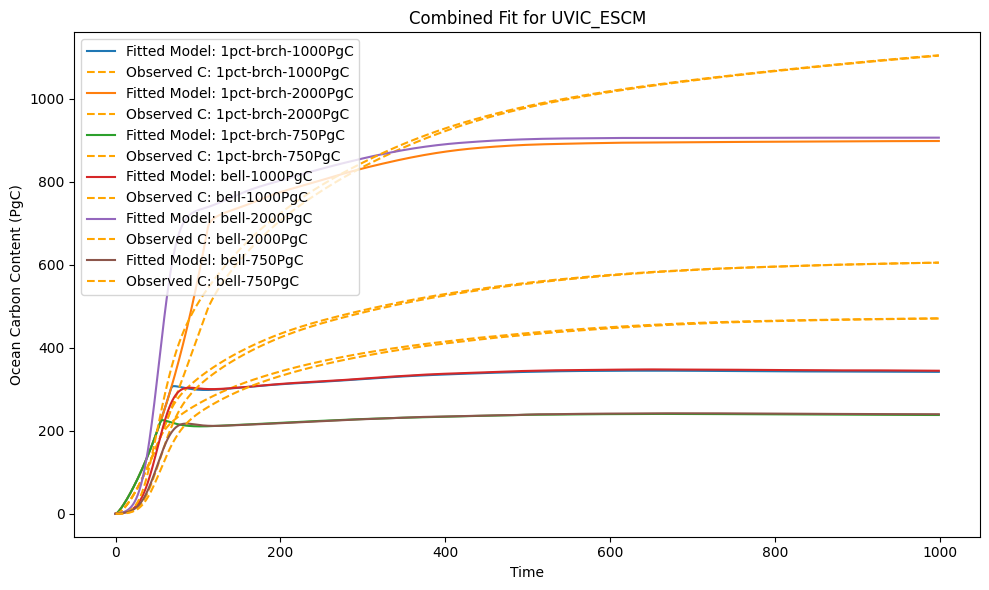

In [241]:
# Load data
datasets = ['1pct-brch-1000PgC', '1pct-brch-2000PgC', '1pct-brch-750PgC', 'bell-1000PgC', 'bell-2000PgC', 'bell-750PgC']

fgco2 = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-1pct-brch-1000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-bell-2000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-bell-750PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-bell-1000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-1pct-brch-2000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/fgco2_UVicESCM2.10_esm-1pct-brch-750PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
}

conc = {
    '1pct-brch-1000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-1pct-brch-1000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-bell-2000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-bell-750PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    'bell-1000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-bell-1000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-2000PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-1pct-brch-2000PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
    '1pct-brch-750PgC': pd.read_csv('all_zecmip/UVIC_ESCM/UVic_ESCM/co2_UVicESCM2.10_esm-1pct-brch-750PgC_1850-3049.csv', index_col=0).to_numpy().flatten(),
}

plt , scale_values_df = ESM_fitting_procedure(dataset_name = 'UVIC_ESCM', fgco2 = fgco2, conc = conc, datasets = datasets, scale_values_df = scale_values_df)


In [242]:
print(scale_values_df)
scale_values_df.to_csv('ESM_scale_values.csv', index=False)

         Dataset         alpha          beta         gamma         delta
0        CanESM5  2.320320e-10  2.764704e+00  2.980253e+00  1.687894e-10
1         ACCESS  1.461510e-10  3.359260e+00  1.414959e+00  2.734344e-10
2           CESM  1.451735e+00  1.314405e+00  8.905042e+00  4.471135e-14
3       CLIMBER2  6.635173e-01  1.805584e+00  1.083772e+01  5.498356e-17
4    CNRM-ESM2-1  5.346765e-14  1.584083e+00  6.749246e+00  1.480563e-18
5          DCESS  6.647073e-01  4.720581e-01  8.392689e+00  1.619106e-14
6     GFDL-ESM2M  2.037161e-09  4.440806e+00  3.622937e+00  1.986841e-26
7         IAPRAS  1.063863e-12  4.839175e+00  5.515552e+00  9.617752e-11
8       LOVECLIM  3.970271e-07  9.249080e-01  9.363511e+00  3.449200e-30
9           MESM  6.369965e-01  2.592258e+00  8.417710e+00  7.698587e-14
10    MIROC-ES2L  2.927005e+00  2.232846e+00  6.658530e-17  1.282065e+01
11    MIROC-lite  1.047698e-02  2.116441e-07  1.423132e+01  4.833244e-15
12        MPIESM  1.300711e+00  1.320840e+00  1.058

In [243]:
ESM_q_values_df = pd.read_csv('/Users/mert4908/Documents/FAIR-200/notebooks/ESM_scale_values.csv')

ESM_q_values_df[['q1', 'q2', 'q3', 'q4']] = ESM_q_values_df[['alpha', 'beta', 'gamma', 'delta']].multiply([0.180, 0.297, 0.386, 0.001], axis=1)

ESM_q_values_df['cumulative_sum'] = ESM_q_values_df[['q1', 'q2', 'q3', 'q4']].sum(axis=1)

print(ESM_q_values_df)

         Dataset         alpha          beta         gamma         delta  \
0        CanESM5  2.320320e-10  2.764704e+00  2.980253e+00  1.687894e-10   
1         ACCESS  1.461510e-10  3.359260e+00  1.414959e+00  2.734344e-10   
2           CESM  1.451735e+00  1.314405e+00  8.905042e+00  4.471135e-14   
3       CLIMBER2  6.635173e-01  1.805584e+00  1.083772e+01  5.498356e-17   
4    CNRM-ESM2-1  5.346765e-14  1.584083e+00  6.749246e+00  1.480563e-18   
5          DCESS  6.647073e-01  4.720581e-01  8.392689e+00  1.619106e-14   
6     GFDL-ESM2M  2.037161e-09  4.440806e+00  3.622937e+00  1.986841e-26   
7         IAPRAS  1.063863e-12  4.839175e+00  5.515552e+00  9.617752e-11   
8       LOVECLIM  3.970271e-07  9.249080e-01  9.363511e+00  3.449200e-30   
9           MESM  6.369965e-01  2.592258e+00  8.417710e+00  7.698587e-14   
10    MIROC-ES2L  2.927005e+00  2.232846e+00  6.658530e-17  1.282065e+01   
11    MIROC-lite  1.047698e-02  2.116441e-07  1.423132e+01  4.833244e-15   
12        MP

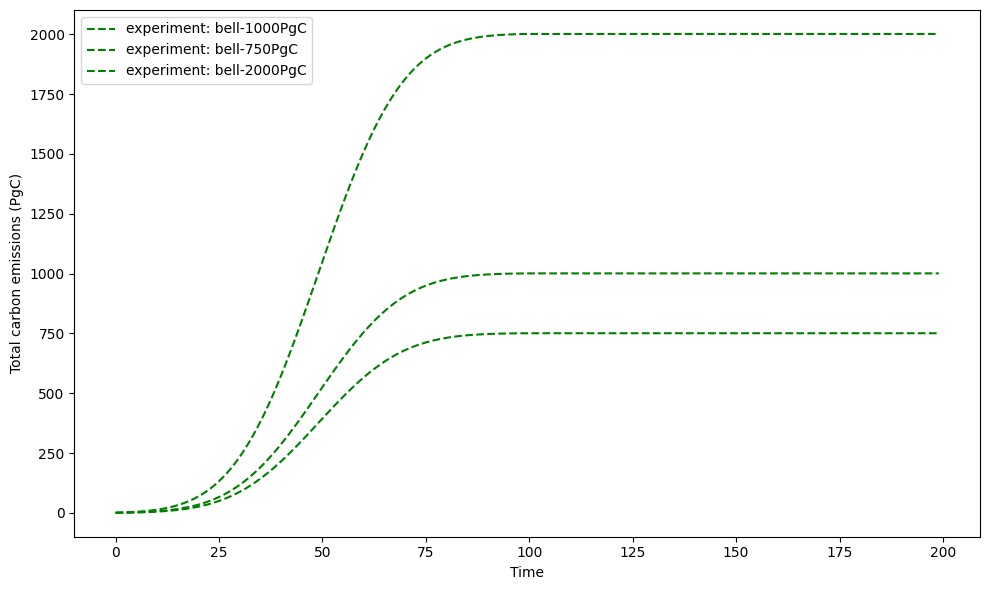

In [244]:
emissions = {
    'bell-1000PgC': pd.read_csv('/Users/mert4908/Documents/FAIR-200/notebooks/ZEC-MIP_Bellcurve_1000PgC.csv', index_col=0, dtype = float, skiprows = 4).to_numpy().flatten(),
    'bell-750PgC': pd.read_csv('/Users/mert4908/Documents/FAIR-200/notebooks/ZEC-MIP_Bellcurve_750PgC.csv', index_col=0, dtype = float, skiprows = 4).to_numpy().flatten(),
    'bell-2000PgC': pd.read_csv('/Users/mert4908/Documents/FAIR-200/notebooks/ZEC-MIP_Bellcurve_2000PgC.csv', index_col=0, dtype = float, skiprows = 4).to_numpy().flatten(),
}

datasets = ['bell-1000PgC', 'bell-750PgC', 'bell-2000PgC']

plt.figure(figsize=(10, 6))

for label in datasets:
    emissions_data = emissions[label]
    c_tot = np.cumsum(emissions_data)

    time = np.arange(len(c_tot))

    # Plot the fitted model and the observed data
    plt.plot(time, c_tot, 'green', label=f'experiment: {label}', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('Total carbon emissions (PgC)')
plt.legend()
plt.tight_layout()